In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

from importlib import reload
import visualise_speed as vs
reload(vs)

from celluloid import Camera
from IPython.display import clear_output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import warnings
import os
warnings.filterwarnings('ignore')

from IPython.display import clear_output
from IPython.display import Video

In [2]:
def plot_run_path(data_folder):
    files = sorted(os.listdir(data_folder))
    runs = files[-5:]

    for i, r in enumerate(runs):
        plt.figure(1, (10, 10))
        data = vs.load_data(f"{data_folder}/{r}")
        data = data[data.Step > 20]
        for e in range(data.Episode.max()):
            ep = data[data.Episode == e]
            if len(ep) > 0:
                plt.plot(ep.PosX, ep.PosZ, color="k", alpha=0.2)
                if len(ep) < 1000:
                    plt.plot(ep.PosX.values[-1], ep.PosZ.values[-1], marker="x", color = "k")

    plt.show()

# The traditional track (Figure 8)

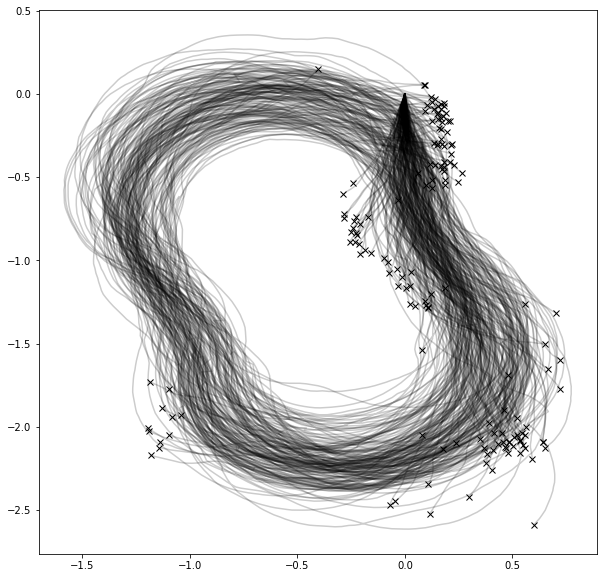

In [3]:
plot_run_path("./results/real_sac/figure_8/")

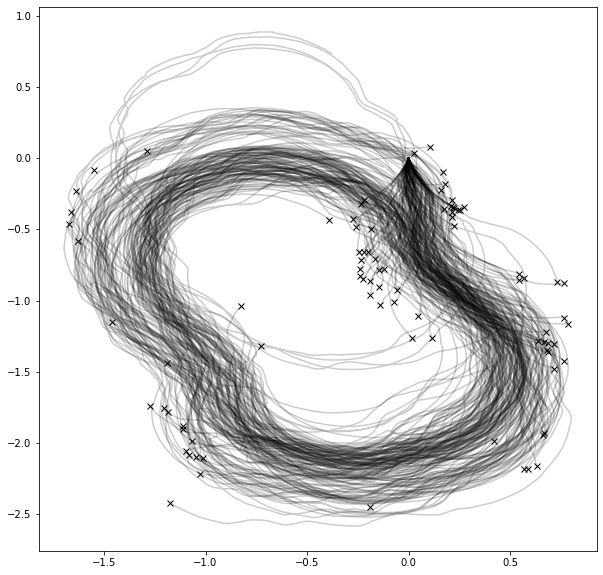

In [14]:
plot_run_path("./results/real_dreamer/figure_8/")

# Race track (haven't come up with a good name)

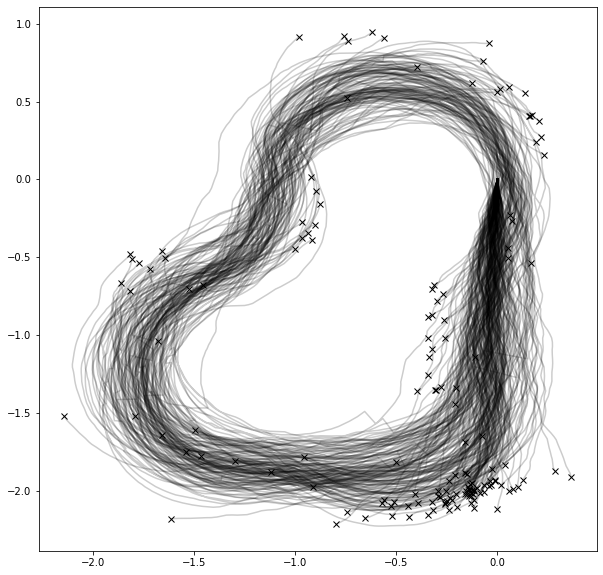

In [4]:
plot_run_path("./results/real_sac/track_aug/")

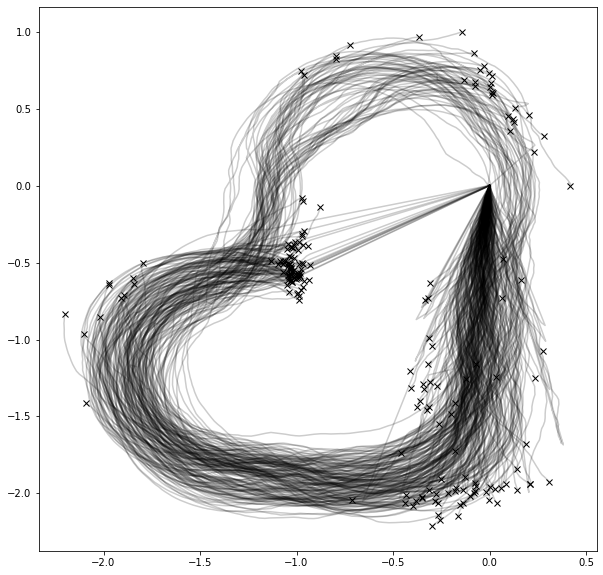

In [5]:
plot_run_path("./results/real_sac/track/")

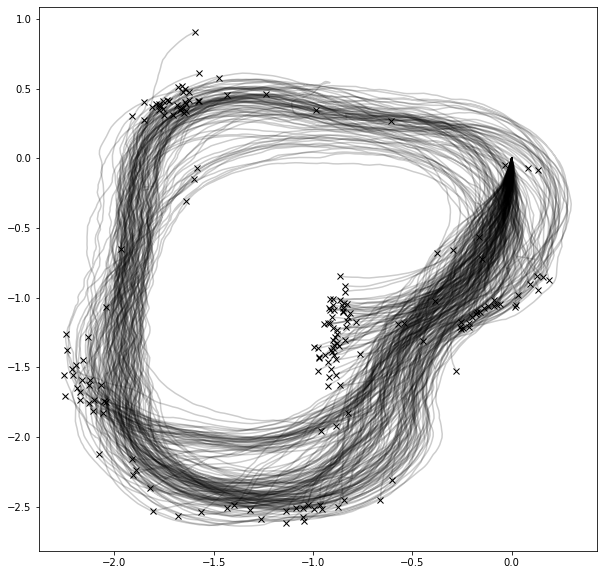

In [6]:
plot_run_path("./results/real_sac/track_favorable_start/")

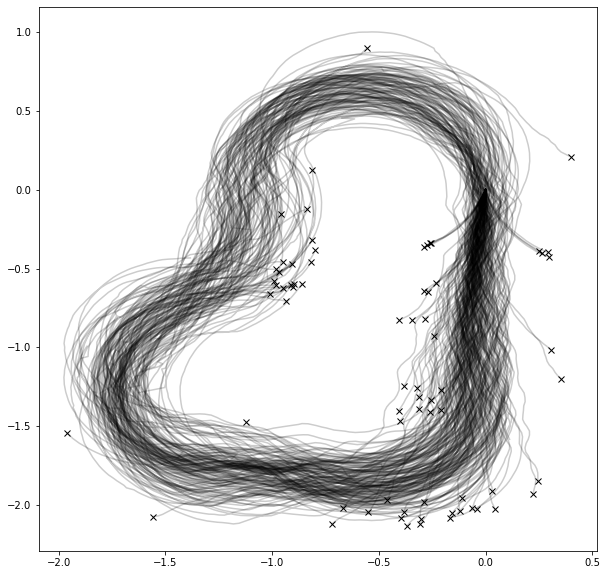

In [27]:
plot_run_path("./results/real_dreamer/track/")

# Square

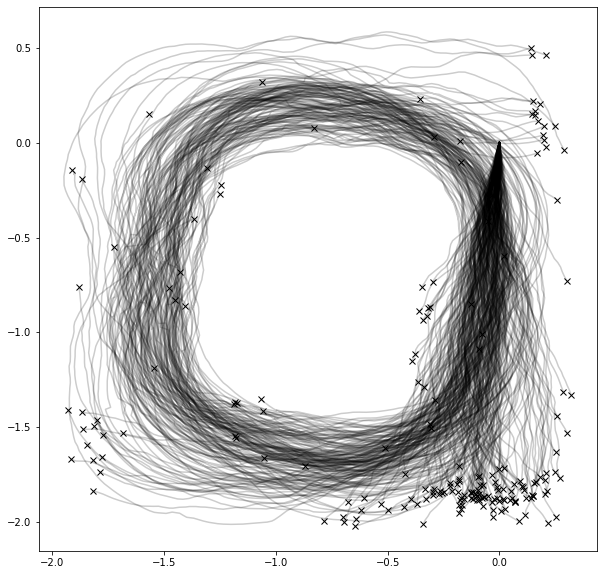

In [9]:
plot_run_path("./results/real_sac/square/")

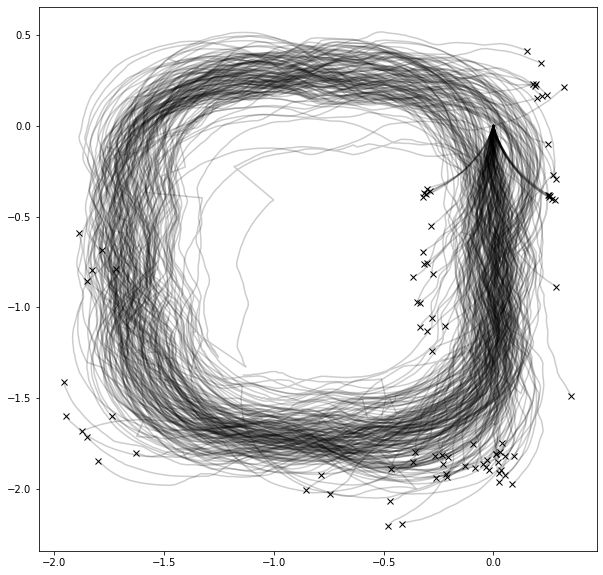

In [11]:
plot_run_path("./results/real_dreamer/square/")

In [21]:
def plot_run(data_folder, label):

    runs = sorted([x for x in os.listdir(data_folder) if ".ipy" not in x])

    total = []

    for i, r in enumerate(runs):
        data = vs.load_data(f"{data_folder}/{r}")
        data = data[data.Step > 20]
        episode_lengths = data.groupby("Episode").max().Step
        cum_env_steps = [0] + list(data.groupby("Episode").max().Step.cumsum()[:-1])

        interp = interp1d(cum_env_steps, episode_lengths, fill_value="extrapolate")
        interp_x = np.arange(10000)

        rewards = interp(interp_x)
        #print(rewards)
        total += zip(interp_x, rewards)
        #plt.scatter(cum_env_steps, episode_lengths, marker="x", alpha=1, label=f"Run {i + 1}")
        #plt.plot(cum_env_steps, episode_lengths.rolling(3).mean())

    total.sort(key=lambda x: x[0])

    all_cum_steps = [x[0] for x in total]
    all_episode_lengths = [x[1] for x in total]

    step_rewards = pd.DataFrame(data={"steps": all_cum_steps, "reward": all_episode_lengths})

    steps = step_rewards.groupby("steps").mean().reset_index()
    std = step_rewards.groupby("steps").std().reset_index()
    plt.plot(steps["steps"], steps["reward"], linewidth=2, label=label)
    plt.fill_between(steps["steps"], steps["reward"] - std["reward"], steps["reward"] + std["reward"], alpha=0.1)
    plt.ylim(0,1100)
    #plt.axhline(300, linestyle="--", color="r", label="One lap")
    plt.xlabel("Cumulative environment steps")
    plt.ylabel("Episode reward")
    plt.legend()

# Square

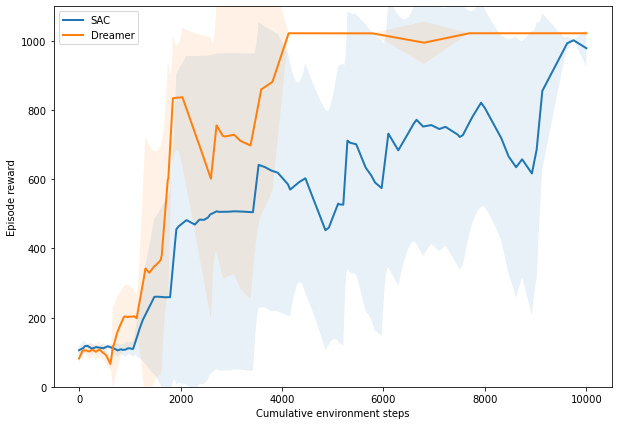

In [22]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/square/", "SAC")
plot_run("./results/real_dreamer/square/", "Dreamer")


# Figure 8
This is with the old setup with dreamer with 64x64 RGB and SAC has mirror augmentation so for full comparison this should probably be done again.

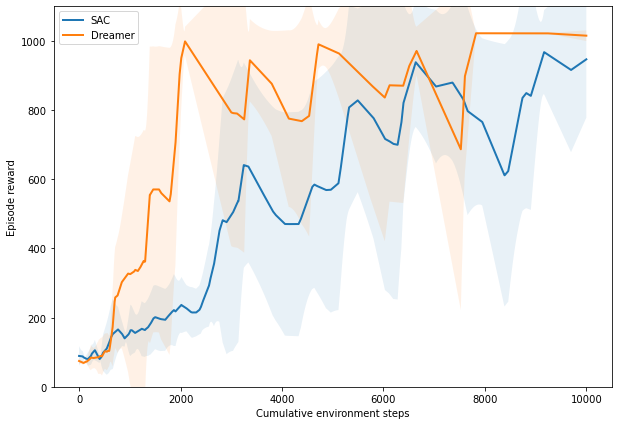

In [23]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/figure_8/", "SAC")
plot_run("./results/real_dreamer/figure_8/", "Dreamer")

# Race track

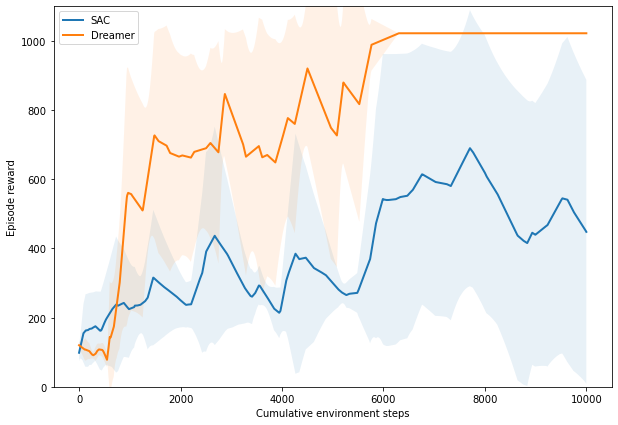

In [26]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/track", "SAC")
plot_run("./results/real_dreamer/track/", "Dreamer")
plt.show()

This is a kind of an ablation study also. When I did runs for the race track, the car did not learn to drive well. I started the car at the beginning of the long straight and by the time the car got to the only right turn it had such a srong bias to turning left that it couldn't make the right turn. Only 2/5 runs learned to get past that turn.

I then tried from another spot where the car saw both turns early and it learned to drive much better. Then I also tried to do the image augmentation where I also introduce mirror images and controls to the replay buffer and this pretty much eliminates the sesitivity to the initial position and learns to drive even from the unfavorable start.

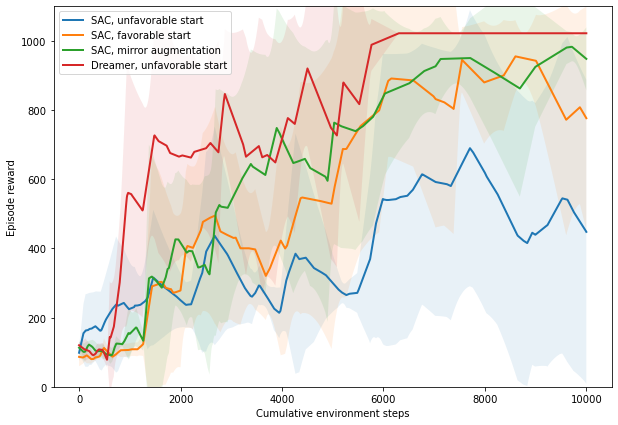

In [25]:
plt.figure(1, (10, 7))
plot_run("./results/real_sac/track", "SAC, unfavorable start")
plot_run("./results/real_sac/track_favorable_start", "SAC, favorable start")
plot_run("./results/real_sac/track_aug", "SAC, mirror augmentation")
plot_run("./results/real_dreamer/track/", "Dreamer, unfavorable start")
plt.show()